In [3]:
# Required Libraries

#Base and Cleaning 
import json
import requests
import pandas as pd
import numpy as np
import emoji
import regex
import re
import string
from collections import Counter

#Visualizations
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt 
import pyLDAvis.gensim
import chart_studio
import chart_studio.plotly as py 
import chart_studio.tools as tls

#Natural Language Processing (NLP)
import spacy
import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)
     

In [4]:
df = pd.read_csv("Tweets.csv", encoding='utf-8')
df.head(15)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive


In [5]:
df = df.drop(columns="selected_text")

In [6]:
df = df.drop(columns="sentiment")

In [7]:
df.rename(columns = {'text':'tweet'}, inplace = True)

In [8]:
df

,textID,tweet
0,cb774db0d1,"I`d have responded, if I were going"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!
2,088c60f138,my boss is bullying me...
3,9642c003ef,what interview! leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t..."
...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...
27479,ed167662a5,But it was worth it ****.


In [9]:
df["tweet"]=df["tweet"].values.astype(str)

In [10]:
def give_emoji_free_text(text):
    emoji_list = [c for c in text if c in emoji.EMOJI_DATA]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

def url_free_text(text):
    text = re.sub(r'http\S+', '', text)
    return text

call_emoji_free = lambda x: give_emoji_free_text(x)

df['emoji_free_tweets'] = df['tweet'].apply(call_emoji_free)

df['url_free_tweets'] = df['emoji_free_tweets'].apply(url_free_text)
     

In [11]:
nlp = spacy.load('en_core_web_lg')

In [12]:
# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [13]:
custom_stopwords = ['hi','\n','\n\n', '&', ' ', '.', '-', 'got', "it's", 'it’s', "i'm", 'i’m','im', 'want', 'like', '$', '@']

# Customize stop words by adding to the default list
STOP_WORDS = nlp.Defaults.stop_words.union(custom_stopwords)

# ALL_STOP_WORDS = spacy + gensim + wordcloud
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)


tokens = []

for doc in tokenizer.pipe(df['url_free_tweets'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
df['tokens'] = tokens

In [14]:
df

,textID,tweet,emoji_free_tweets,url_free_tweets,tokens
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going","I`d have responded, if I were going","[i`d, responded,, going]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD I will miss you here in San Diego!!!,"[sooo, sad, miss, san, diego!!!]"
2,088c60f138,my boss is bullying me...,my boss is bullying me...,my boss is bullying me...,"[boss, bullying, me...]"
3,9642c003ef,what interview! leave me alone,what interview! leave me alone,what interview! leave me alone,"[interview!, leave]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****, why couldn`t they put them on th...","Sons of ****, why couldn`t they put them on th...","[sons, ****,, couldn`t, releases, bought]"
...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,wish we could come see u on Denver husband los...,wish we could come see u on Denver husband los...,"[wish, come, u, denver, husband, lost, job, ca..."
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,I`ve wondered about rake to. The client has ma...,I`ve wondered about rake to. The client has ma...,"[i`ve, wondered, rake, to., client, clear, .ne..."
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you. Enjoy the break - yo...,Yay good for both of you. Enjoy the break - yo...,"[yay, good, you., enjoy, break, probably, need..."
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,But it was worth it ****.,"[worth, ****.]"


In [15]:
df['tokens_back_to_text'] = [' '.join(map(str, l)) for l in df['tokens']]
def get_lemmas(text):
    '''Used to lemmatize the processed tweets'''
    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

df['lemmas'] = df['tokens_back_to_text'].apply(get_lemmas)
     

In [16]:
# Make lemmas a string again
df['lemmas_back_to_text'] = [' '.join(map(str, l)) for l in df['lemmas']]

# Tokenizer function
def tokenize(text):
    # Removing url's
    pattern = r"http\S+"
    
    tokens = re.sub(pattern, "", text) # https://www.youtube.com/watch?v=O2onA4r5UaY
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    tokens = re.sub('@*!*', '', text) # Remove @ ! $
    tokens = tokens.strip(',') # TESTING THIS LINE
    tokens = tokens.strip('?') # TESTING THIS LINE
    tokens = tokens.strip('!') # TESTING THIS LINE
    tokens = tokens.strip("'") # TESTING THIS LINE
    tokens = tokens.strip(".") # TESTING THIS LINE

    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
df['lemma_tokens'] = df['lemmas_back_to_text'].apply(tokenize)
     

<>:12: DeprecationWarning: invalid escape sequence '\w'
<>:12: DeprecationWarning: invalid escape sequence '\w'
/tmp/ipykernel_43116/3831837225.py:12: DeprecationWarning: invalid escape sequence '\w'
  tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers


In [17]:
df

,textID,tweet,emoji_free_tweets,url_free_tweets,tokens,tokens_back_to_text,lemmas,lemmas_back_to_text,lemma_tokens
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going","I`d have responded, if I were going","[i`d, responded,, going]","i`d responded, going","[respond, go]",respond go,"[respond, go]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD I will miss you here in San Diego!!!,"[sooo, sad, miss, san, diego!!!]",sooo sad miss san diego!!!,"[sooo, sad, miss, san, diego]",sooo sad miss san diego,"[sooo, sad, miss, san, diego]"
2,088c60f138,my boss is bullying me...,my boss is bullying me...,my boss is bullying me...,"[boss, bullying, me...]",boss bullying me...,"[boss, bully]",boss bully,"[boss, bully]"
3,9642c003ef,what interview! leave me alone,what interview! leave me alone,what interview! leave me alone,"[interview!, leave]",interview! leave,"[interview, leave]",interview leave,"[interview, leave]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****, why couldn`t they put them on th...","Sons of ****, why couldn`t they put them on th...","[sons, ****,, couldn`t, releases, bought]","sons ****, couldn`t releases bought","[son, couldn`t, release, buy]",son couldn`t release buy,"[son, couldn`t, release, buy]"
...,...,...,...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,wish we could come see u on Denver husband los...,wish we could come see u on Denver husband los...,"[wish, come, u, denver, husband, lost, job, ca...",wish come u denver husband lost job can`t afford,"[wish, come, u, denver, husband, lose, job, ca...",wish come u denver husband lose job can`t afford,"[wish, come, u, denver, husband, lose, job, ca..."
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,I`ve wondered about rake to. The client has ma...,I`ve wondered about rake to. The client has ma...,"[i`ve, wondered, rake, to., client, clear, .ne...","i`ve wondered rake to. client clear .net only,...","[i`ve, wonder, rake, client, clear, .net, don`...",i`ve wonder rake client clear .net don`t force...,"[i`ve, wonder, rake, client, clear, .net, don`..."
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you. Enjoy the break - yo...,Yay good for both of you. Enjoy the break - yo...,"[yay, good, you., enjoy, break, probably, need...",yay good you. enjoy break probably need hectic...,"[yay, good, enjoy, break, probably, need, hect...",yay good enjoy break probably need hectic week...,"[yay, good, enjoy, break, probably, need, hect..."
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,But it was worth it ****.,"[worth, ****.]",worth ****.,[worth],worth,[worth]


## Topic Modeling

In [18]:
# Create a id2word dictionary
id2word = Dictionary(df['lemma_tokens'])
print(len(id2word))

23142


In [19]:
id2word

In [20]:
# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
print(len(id2word))

8605


In [21]:
# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in df['lemma_tokens']]

In [22]:
# Instantiating a Base LDA model 
base_model = LdaMulticore(corpus=corpus, num_topics=5, id2word=id2word, workers=12, passes=5)

In [23]:
# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

In [24]:
# Create Topics
topics = [' '.join(t[0:10]) for t in words]

In [25]:
# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
work good home day i`m know today go u wish

------ Topic 1 ------
day go happy good it`s work to miss i`m today

------ Topic 2 ------
love thank haha know look i`m day good it`s can`t

------ Topic 3 ------
i`m ` oh night feel not sorry twitter yeah think

------ Topic 4 ------
good go time day lol i`m don`t today think can`t



In [26]:
t=[]
for i in topics:
    tmp = i.split()
    t.extend(tmp)

In [27]:
from wordcloud import WordCloud

In [29]:
wordcloud = WordCloud(background_color='lightgreen',width = 2000, height = 1000).generate(' '.join(t))

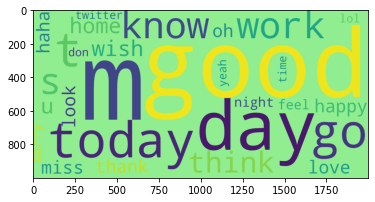

In [30]:
plt.imshow(wordcloud)

Thank you